from: https://github.com/kvgarimella/botorch-tutorial/blob/main/simple-botorch-tutorial.ipynb

In [6]:
import torch
import numpy as np
from tqdm import tqdm

from botorch.fit import fit_gpytorch_model
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
from botorch.acquisition import ExpectedImprovement, UpperConfidenceBound


import matplotlib.pyplot as plt
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()


### Fit GP model to dataset
The following function (get_model) fits a Gaussian Process to a set of observations.

In [2]:
## build GP model
## initialize a GP with data
## use likelihood to find GP params
def get_model(train_x, train_y, state_dict=None, debug=False):
    gp  = SingleTaskGP(train_x, train_y)
    if debug:
        print("Prior hyperparams lengthscale & noise: {}, {}".format(gp.covar_module.base_kernel.lengthscale.item(), gp.likelihood.noise.item()))
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    if state_dict is not None:
        gp.load_state_dict(state_dict) # speeds up fit
    fit_gpytorch_model(mll) # performs the hyperparam fit
    if debug:
        print("Post hyperparams lengthscale & noise:  {}, {}".format(gp.covar_module.base_kernel.lengthscale.item(), gp.likelihood.noise.item()))
    return gp, mll

### Target Function
The function we would like to maximize.



In [3]:
def target(x):
    return torch.exp(-(x - 2)**2) + torch.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)


### Random Init
Randomly sample search space to warm up Gaussian Process

In [4]:
# random start
train_x = torch.FloatTensor(4, 1).uniform_(-2., 10.)

# train_x   = torch.tensor([[3.109], [7.775]])
train_obj = target(train_x)
model, mll = get_model(train_x, train_obj,debug=True)

train_x_explore = torch.clone(train_x)
train_obj_explore = torch.clone(train_obj)
model_explore, mll_explore = get_model(train_x, train_obj,debug=True)

Prior hyperparams lengthscale & noise: 0.6931471824645996, 2.000000476837158
Post hyperparams lengthscale & noise:  0.30493125319480896, 0.004062082152813673
Prior hyperparams lengthscale & noise: 0.6931471824645996, 2.000000476837158
Post hyperparams lengthscale & noise:  0.30493125319480896, 0.004062082152813673


### Plot Target
We can see that the max is at .

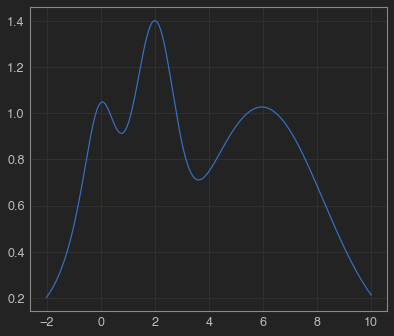

In [7]:
x = torch.linspace(-2, 10, 10000).reshape(-1, 1)
y = target(x)

plt.plot(x, y);

The following function finds the maximum of the Acquisition Function. (only used for plotting purposes)



In [8]:
def get_max(model,beta):
    UCB      = UpperConfidenceBound(model=model, beta=beta)
    new_point_analytic, acq_value_list = optimize_acqf(
                acq_function=UCB,
                bounds=torch.tensor([[-2.], [10.]]),
                q=1,
                num_restarts=20,
                raw_samples=10000,
                options={},
                return_best_only=True,
                sequential=False
    )
    return new_point_analytic, acq_value_list

### One Step of Bayes Opt
step probes a single query point (chosen by the acquisition function) and updates the GP.

In [ ]:
def step(model, mll, train_x, train_obj, beta=5.):
    # optimize acquisition function
    UCB      = UpperConfidenceBound(model=model, beta=beta)
    new_point_analytic, acq_value_list = optimize_acqf(
                acq_function=UCB,
                bounds=torch.tensor([[-2.], [10.]]),
                q=1,
                num_restarts=20,
                raw_samples=10000,
                options={},
                return_best_only=True,
                sequential=False
    )
    smth      = target(new_point_analytic)
    train_obj = torch.cat([smth, train_obj])
    train_x   = torch.cat([new_point_analytic, train_x])

    model, mll = get_model(train_x, train_obj, model.state_dict())
    return model, mll, train_x, train_obj